In [1]:

import sys
# sys.path = ['/home/dakota/anaconda3/lib/python3.8/site-packages'] \
#          + sys.path
import pandas as pd
import numpy as np
import scanpy as sc

from matplotlib import pyplot as plt
import seaborn as sns
import os
plt.style.use('../src/configs/figures.mplstyle')

In [2]:
# ! pip install numba --force-reinstall

In [3]:
adata = sc.AnnData(#X=np.loadtxt('data/Tian/icat/X.csv', delimiter=','),
                   X=np.loadtxt('/home/dakota/Data/Tian/X.csv', delimiter=','),
                   obs=pd.read_csv('data/Tian/obs/icat_cells.csv', index_col=0),
                   var=pd.read_csv('data/Tian/icat/var.csv', index_col=0))
adata.obs.mixture.replace({'0,0,9': 'HCC827',
                           '0,9,0': 'H2228',
                           '3,3,3': 'Mixed',
                           '9,0,0': 'H1975'},
                         inplace=True)
adata.obs.mixture = pd.Categorical(adata.obs.mixture,
                                   sorted(adata.obs.mixture.unique()))
adata.obs.rename(columns={'mixture': 'Cell Mixture'}, inplace=True)
adata.obs.Cluster = pd.Categorical(adata.obs.Cluster)

In [4]:
subset = adata[:, adata.var.informative].copy()

... storing 'benchmark' as categorical
... storing 'cell_line' as categorical
... storing 'cell_line_demuxlet' as categorical
... storing 'demuxlet_cls' as categorical
... storing 'poor_quality' as categorical
... storing 'traj' as categorical


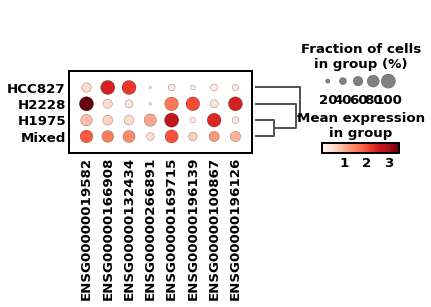

In [5]:
sc.pl.dotplot(subset, subset.var.index, groupby='Cell Mixture',
              dendrogram=True)

In [6]:
subset.var.index

Index(['ENSG00000019582', 'ENSG00000166908', 'ENSG00000132434',
       'ENSG00000266891', 'ENSG00000169715', 'ENSG00000196139',
       'ENSG00000100867', 'ENSG00000196126'],
      dtype='object')

In [7]:
markers = ['ENSG00000266891',
           'ENSG00000100867',
           'ENSG00000196139',
           'ENSG00000196126',
           'ENSG00000166908',
           'ENSG00000132434']

names = ['RP11-692N5.2',
         'DHRS2',
         'AKR1C3',
         'HLA-DRB1',
         'PIP4K2C',
         'LANCL2']

In [8]:
from sklearn.preprocessing import MinMaxScaler
subset.X = MinMaxScaler().fit_transform(subset.X)

In [11]:
# 0 -> 900
# 1 -> 009
# 2 -> 090
def dimension_and_dotplot(adata, markers, names, x='UMAP1', y='UMAP2',
                          icat=True):    
    fig = plt.figure(figsize=(15, 6), constrained_layout=False)
    gs = fig.add_gridspec(6, 15)
    ax1 = fig.add_subplot(gs[0:3, 0:3])
    ax = sns.scatterplot(data=adata.obs, x=x, y=y,
                         hue='Cell Mixture', edgecolor=None, s=35,
                         hue_order=adata.obs['Cell Mixture'].cat.categories,
                         alpha=0.7, ax=ax1)
    ax.legend_.set_bbox_to_anchor((1,1))
    ax.set_xticks([])
    ax.set_yticks([])

    ax2 = fig.add_subplot(gs[3:, 0:3])
    ax = sns.scatterplot(data=adata.obs, x=x, y=y,
                         hue='Cluster', edgecolor=None, s=35,
                         alpha=0.7,
                         palette=sns.color_palette('husl', adata.obs.Cluster.nunique()),
                         ax=ax2)
    ax.legend_.set_bbox_to_anchor((1,1))
    ax.set_xticks([])
    ax.set_yticks([])

    groupby = 'Cell Mixture'
    plotdata = adata
    pos = None
    labels = None
    vmax = 1
    clusters = 'icat_cluster'
    if icat:
        clusters = 'Cluster'
        pos = [(0, 1), (2, 3), (4, 5)]
        labels = ['H1975', 'H2228', 'HCC827']
        vmax = 0.75
    plotdata.var['name'] = None
    plotdata.var.loc[markers, 'name'] = names
    ax3 = fig.add_subplot(gs[:, 5:10])
    fig.subplots_adjust(hspace=0.7)
    sc.pl.stacked_violin(adata, names, groupby='Cell Mixture',
                         gene_symbols='name',
                         var_group_positions=pos,
                         var_group_labels=labels,
#                          swap_axes=True,
                         vmin=0,
                         vmax=vmax,
                         show=False, #,
                         ax=ax3)
    ax4 = fig.add_subplot(gs[:, 10:])
    mixture = adata[adata.obs['Cell Mixture'] == 'Mixed', :].copy()
    out = sc.pl.stacked_violin(mixture, names, groupby=clusters,
                               gene_symbols='name',
                               var_group_positions=pos,
                               var_group_labels=labels,
#                                swap_axes=True,
                               categories_order=[0, 2, 1],
                               vmin=0,
                               vmax=vmax,
                               show=False,
                               ax=ax4)
    out['mainplot_ax'].set_ylabel('ICAT\nclusters')
#     ax3.set_xticklabels(ax3.get_xticklabels(), fontsize=14)
    return fig

figdir = os.path.join('figures', 'tian_exp')
if not os.path.exists(figdir):
    os.makedirs(figdir)

sc.set_figure_params(scanpy=False, fontsize=22)

In [12]:
hi = dimension_and_dotplot(subset, markers, names, 'PC1', 'PC2')
# plt.savefig(os.path.join(figdir, 'icat_pca.svg'))

... storing 'name' as categorical


In [11]:
scan = sc.AnnData(X=np.loadtxt('data/Tian/icat_scan/X.csv', delimiter=','),
                  obs=pd.read_csv('data/Tian/obs/icat_scan_cells.csv', index_col=0),
                  var=pd.read_csv('data/Tian/icat_scan/var.csv', index_col=0))
informative = scan.var[scan.var.informative].index.values
scan.obs.mixture.replace({'0,0,9': 'HCC827',
                          '0,9,0': 'H2228',
                          '3,3,3': 'Mixed',
                          '9,0,0': 'H1975'},
                         inplace=True)
scan.obs.mixture = pd.Categorical(scan.obs.mixture,
                                   sorted(scan.obs.mixture.unique()))
scan.obs.rename(columns={'mixture': 'Cell Mixture'}, inplace=True)
scan.obs.Cluster = pd.Categorical(scan.obs.Cluster)
scan.X = MinMaxScaler().fit_transform(scan.X)
subset.obs.index = subset.obs.apply(lambda x: '-'.join(x.name.split('-')[:-1]), axis=1)
scan.obs.index = scan.obs.apply(lambda x: '-'.join(x.name.split('-')[:-2]), axis=1)
scan.obs['icat_cluster'] = None
scan.obs.loc[subset.obs.index, 'icat_cluster'] =  subset.obs['Cluster']

... storing 'name' as categorical


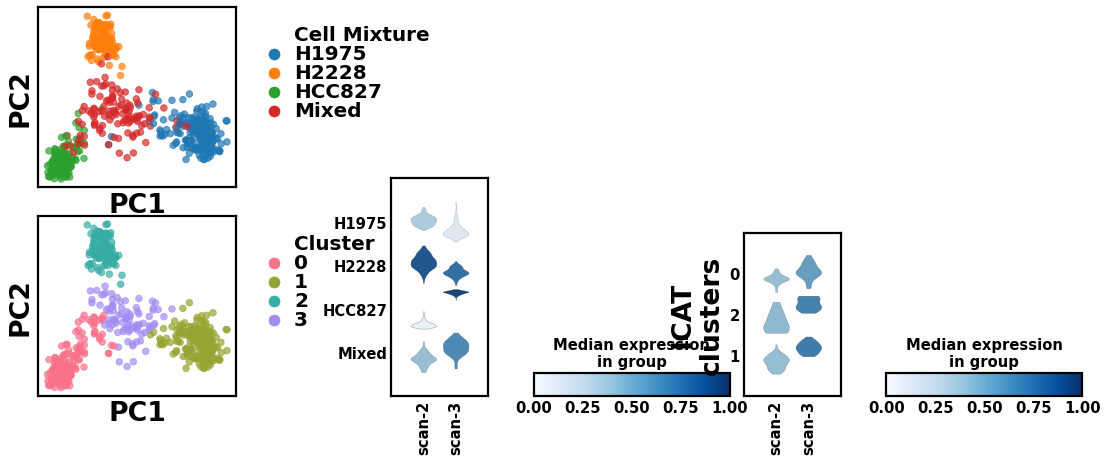

In [27]:
out = dimension_and_dotplot(scan, informative, informative, 'PC1', 'PC2',
                            icat=False)
plt.savefig(os.path.join(figdir, 'icat_scan_pcas.svg'))